# Iris Dataset Classification with apenet's Neural Network

This notebook demonstrates how to build, train, and evaluate a neural network model using the apenet library, using the Iris Dataset as an example.

## Import Libraries

In [23]:
import numpy as np
## Data processing
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Import our library
from apenet.eye.visuals import plot_history

from apenet.nn.models.builder import ModelBuilder
from apenet.nn.train.trainer import Trainer
from apenet.nn.utils.data import train_test_split
from apenet.nn.loss.losses import CrossEntropyLoss
from apenet.nn.optimizers.optimizers import SGD

# Data Overview

## Load Data


In [24]:
# Load and preprocess data
X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True, as_frame=False)

## Data Visualization

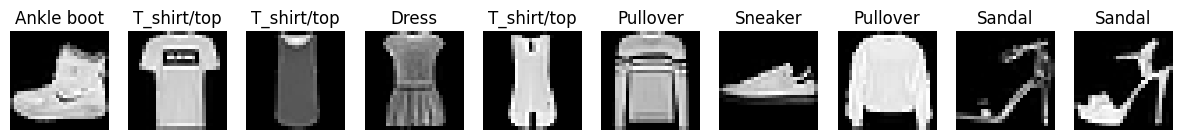

In [25]:
# Visualize some examples from the dataset
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.set_title(class_names[y.astype(int)[i]])
    ax.axis('off')
plt.show()

## Preprocess Data


In [ ]:
# Normalize images
print(X)
y = y.astype(int)
print(X[0] == X[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Print the sizes of the training and test datasets
print(f"Training dataset size: {X_train.shape}")
print(f"Test dataset size: {X_test.shape}")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Training dataset size: (56000, 784)
Test dataset size: (14000, 784)


# Model Overview

## Create Model


In [ ]:
builder = ModelBuilder()
input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))
hidden_sizes = [512, 256, 128, 64]

model = builder.build_mlp(
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    output_size=num_classes,
    hidden_activation='relu',
    output_activation=None,
    initializer='Xavier'
)

learning_rate = 0.01
epochs = 20
batch_size = 128

## Define Loss Function and Optimizer


In [28]:
loss_fn = CrossEntropyLoss()
optimizer = SGD(model.get_parameters(), learning_rate=learning_rate)

## Create Trainer


In [29]:
# Create trainer
trainer = Trainer(model, loss_fn, optimizer)

## Train Model


In [ ]:
# Train model
history = trainer.train(
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test
)


Epoch 1/100: train_loss=1.5153, train_accuracy=0.7256, val_loss=0.7461, val_accuracy=0.7691
Epoch 11/100: train_loss=0.3544, train_accuracy=0.8704, val_loss=0.4565, val_accuracy=0.8407
Epoch 21/100: train_loss=0.2945, train_accuracy=0.8925, val_loss=0.4223, val_accuracy=0.8529


KeyboardInterrupt: 

## Evaluate Model


In [ ]:
# Evaluate model
metrics = trainer.evaluate(X_test, y_test)
print(f"Test Loss: {metrics['loss']:.4f}, Test Accuracy: {metrics['accuracy']:.4f}")

Test Loss: 0.3787, Test Accuracy: 0.8697


## Plot Training History


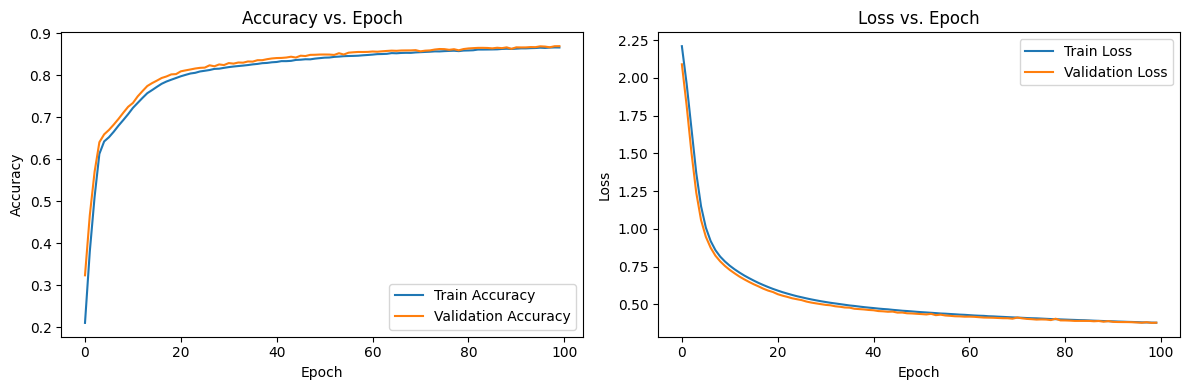

In [ ]:
# Plot training history
plot_history(history)